<h1>Считывание данных</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file = "aes_data.xlsx"

data = pd.read_excel(file)

df = data.drop([0,1,2], axis=0)
cols_fillna = df.columns.values
for col in cols_fillna[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    
pump_in_cols = df.columns.values[1:6]
pump_out_cols = df.columns.values[6:11]
pump_mass_cols = df.columns.values[11:16]
pump_temp_col = df.columns.values[16]
pump_amper_cols = df.columns.values[17:22]
pump_revs_cols = df.columns.values[22:27]
pump_volt_cols = df.columns.values[27:31]
pump_turbine_col = df.columns.values[31]
pump_reactor_col = df.columns.values[32]


# df[cols_fillna[-1]][df[cols_fillna[-1]].isnull()]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.head()


,Время,10LAB11CP002_XQ01,10LAB12CP002_XQ01,10LAB13CP002_XQ01,10LAB14CP002_XQ01,10LAB15CP002_XQ01,10LAB11CP003_XQ01,10LAB12CP003_XQ01,10LAB13CP003_XQ01,10LAB14CP003_XQ01,10LAB15CP003_XQ01,10LAB11CF001_XQ01,10LAB12CF001_XQ01,10LAB13CF001_XQ01,10LAB14CF001_XQ01,10LAB15CF001_XQ01,10LAB00FT902_XQ01,10LAC11CE021_XQ01,10LAC12CE021_XQ01,10LAC13CE021_XQ01,10LAC14CE021_XQ01,10LAC15CE021_XQ01,10LAC11CS001A_XQ01,10LAC12CS001A_XQ01,10LAC13CS001A_XQ01,10LAC14CS001A_XQ01,10LAC15CS001A_XQ01,10BBA00CE010_XQ01,10BBB00CE010_XQ01,10BBC00CE010_XQ01,10BBD00CE010_XQ01,10MKA10CE912_XQ01,10JKS00FU901_XQ01
0,NaN,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание
1,NaN,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост ВЧСЛ СИГН Т ПИТВ Д 0-200 ГРАД,дост ТОК 10LAC11AP001 0-600 А,дост ТОК 10LAC12AP001 0-600 А,дост ТОК 10LAC13AP001 0-600 А,дост ТОК 10LAC14AP001 0-600 А,дост ТОК 10LAC15AP001 0-600 А,дост Частота вращения ротора электродвигателя,дост Частота вращения ротора электродвигателя,дост Частота вращения ротора электродвигателя,дост Частота вращения ротора электродвигателя,дост Частота вращения ротора электродвигателя,дост U НА СЕКЦ BBA 0-13 КВ,дост U НА СЕКЦ BBB 0-13 КВ,дост U НА СЕКЦ BBC 0-13 КВ,дост U НА СЕКЦ BBD 0-13 КВ,дост -100-1500 MBT,дост Среднее значение мощности реактора
2,NaN,МПа,МПа,МПа,МПа,МПа,МПа,МПа,МПа,МПа,МПа,кг/с,кг/с,кг/с,кг/с,кг/с,°C,A,A,A,A,A,об/мин,об/мин,об/мин,об/мин,об/мин,кВ,кВ,кВ,кВ,МВт,МВт
3,01.01.19 00:00:00,0.80,0.76,0.75,0.80,0.77,0.7,9.4,9.5,0.8,9.5,-1,293,383,1,343,167,0,282,290,1,280,0,2995,2994,0,2995,10.5,10.2,10.5,10.4,576,1803
4,01.01.19 01:00:00,0.80,0.76,0.75,0.80,0.77,0.7,9.4,9.5,0.8,9.5,-1,294,383,1,342,167,0,278,290,1,277,0,2995,2996,0,2995,10.5,10.2,10.5,10.4,575,1795


<AxesSubplot:>

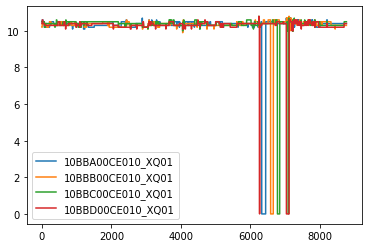

In [2]:
df[pump_volt_cols].plot()

<h1>Первичная фильтрация данных</h1>
<p>убираем отрицательные или слишком большие значения</p>
<p>+ графики массовой подачи для всех насосов</p>


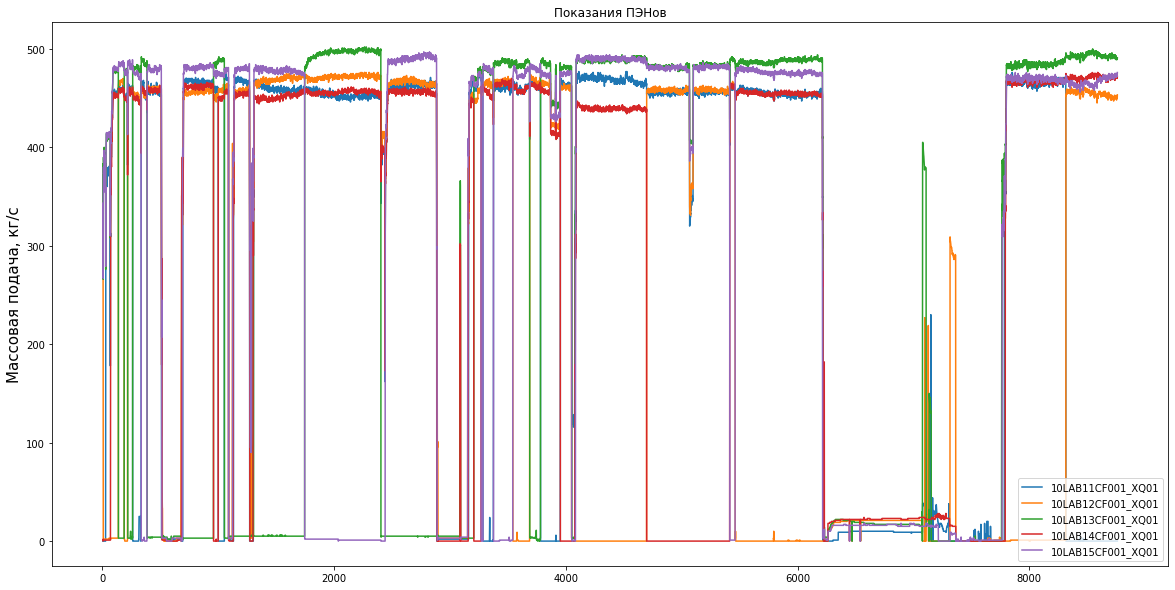

In [3]:
# df["10LAB13CP002_XQ01"] = df.loc[df["10LAB13CP002_XQ01"]>8, "10LAB13CP002_XQ01"].apply(lambda x: x-x//1)


df["10LAB13CP002_XQ01"] = df["10LAB13CP002_XQ01"].apply(lambda x: x if x<=8 else x-x//1)   


for col in df.columns.values[1:]:
    df[col] = df[col].apply(lambda x: 0 if x<0 else x)

# pump_columns = ["10LAB11CP002_XQ01","10LAB12CP002_XQ01","10LAB13CP002_XQ01","10LAB14CP002_XQ01","10LAB15CP002_XQ01"]
pump_columns = ["10LAB11CF001_XQ01","10LAB12CF001_XQ01","10LAB13CF001_XQ01","10LAB14CF001_XQ01","10LAB15CF001_XQ01"]

for col in pump_mass_cols:
    df[col] = df[col].apply(lambda x: x if x<510 else 0)    

    
plt.rcParams["figure.figsize"] = (20,10)

plot = df.plot(use_index=True, y=pump_columns)
plt.title('Показания ПЭНов')
plt.ylabel('Массовая подача, кг/с', fontsize=15)
plt.legend(loc='lower right')
plt.show()


<h1>Расчеты КПД</h1>

In [4]:
from iapws import IAPWS97, IAPWS95

def eff_func(row, pump_num):
    p1 = df[f'10LAB{pump_num}CP002_XQ01'][row]
    p2 = df[f'10LAB{pump_num}CP003_XQ01'][row]
    G = df[f'10LAB{pump_num}CF001_XQ01'][row]
    t = df["10LAB00FT902_XQ01"][row]
    I = df[f"10LAC{pump_num}CE021_XQ01"][row]
    U = df["10BBA00CE010_XQ01"][row]
    
    if all([(p2-p1)*G,U*I, t, p2, p1]):
        try:
            rho = IAPWS97(P=(p1+p2)/2, T=t+273).rho
        except:
            print(p1,p2,G,t, pump_num)
            raise Exception('here')
        ef = (p2-p1)*1000*G/(U*I*rho)/np.sqrt(3)
        ef = 0 if ef < 0 or ef >= 1 else ef
        
        return ef / np.sqrt(3)
        
    else:
        return 0


pump_1_eff = df.apply(lambda x: eff_func(x.name, 11), axis=1)
pump_2_eff = df.apply(lambda x: eff_func(x.name, 12), axis=1)
pump_3_eff = df.apply(lambda x: eff_func(x.name, 13), axis=1)
pump_4_eff = df.apply(lambda x: eff_func(x.name, 14), axis=1)
pump_5_eff = df.apply(lambda x: eff_func(x.name, 15), axis=1)

pump_eff_data = {
    'pump_1_eff':pump_1_eff,
    'pump_2_eff':pump_2_eff,
    'pump_3_eff':pump_3_eff,
    'pump_4_eff':pump_4_eff,
    'pump_5_eff':pump_5_eff,
}



Text(0, 0.5, 'КПД насоса')

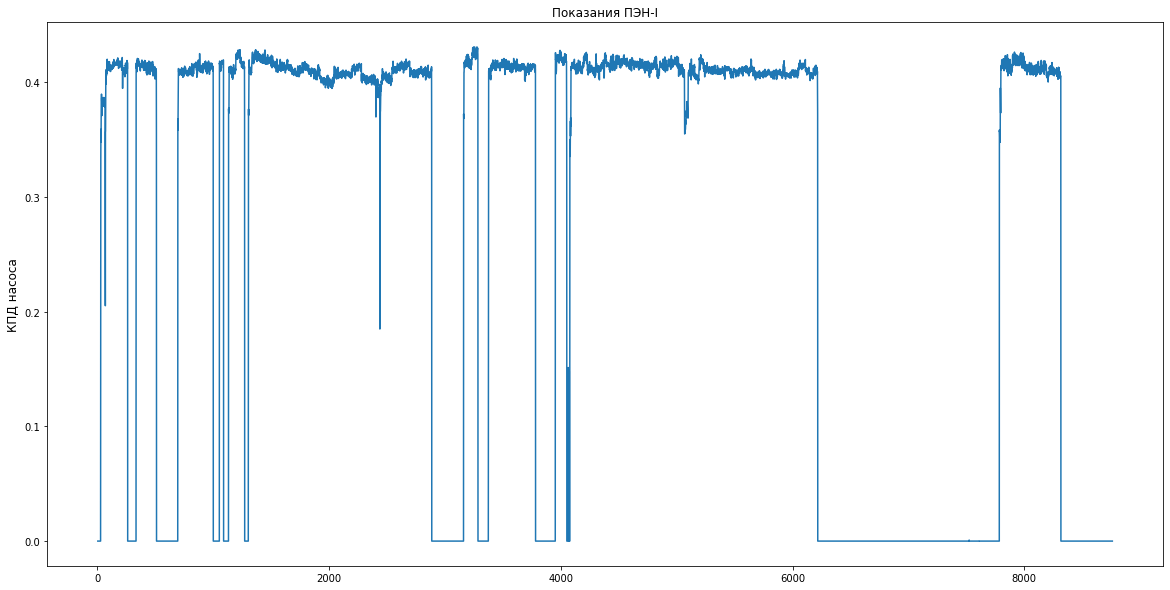

In [5]:
fig = pump_eff_data['pump_1_eff'].plot(title="Показания ПЭН-I")
plt.ylabel("КПД насоса", fontsize=12)


<h1>Разделение на сегменты</h1>

In [6]:
def divide_to_segments_by_eff(column, limiter):
    segm_start = None
    segm_end = None

    segments = []

    for ind,item in pump_eff_data[column].iteritems():
        if item>limiter:
            if segm_start is None:
                segm_start = ind
        else:
            if segm_start is not None and ind != segm_start:
                segm_end = ind

        if segm_start is not None and segm_end is not None:
            segments.append((segm_start-2,segm_end-3))
            segm_start, segm_end = None, None
    
    return segments

def divide_to_segments(column, limiter):
    segm_start = None
    segm_end = None

    segments = []

    for ind,item in df[column].iteritems():
        if item>limiter:
            if segm_start is None:
                segm_start = ind
        else:
            if segm_start is not None and ind != segm_start:
                segm_end = ind

        if segm_start is not None and segm_end is not None:
            segments.append((segm_start,segm_end))
            segm_start, segm_end = None, None
    
    return segments
        
# segments1 = divide_to_segments(pump_mass_cols[0], 350)
# segments2 = divide_to_segments(pump_mass_cols[1], 350)
# segments3 = divide_to_segments(pump_mass_cols[2], 440)
# segments4 = divide_to_segments(pump_mass_cols[3], 400)
# segments5 = divide_to_segments(pump_mass_cols[4], 400)

segments1 = divide_to_segments_by_eff('pump_1_eff', 0.1)
segments2 = divide_to_segments_by_eff('pump_2_eff', 0.1)
segments3 = divide_to_segments_by_eff('pump_3_eff', 0.1)
segments4 = divide_to_segments_by_eff('pump_4_eff', 0.1)
segments5 = divide_to_segments_by_eff('pump_5_eff', 0.1)


pump_mass_1_filtred = pd.concat([df[pump_mass_cols[0]][i[0]-2:i[1]-3] for i in segments1],  ignore_index=True)

filtred_data = {
    'pump_1_in': pd.concat([df[pump_in_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_in': pd.concat([df[pump_in_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_in': pd.concat([df[pump_in_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_in': pd.concat([df[pump_in_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_in': pd.concat([df[pump_in_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
    
    'pump_1_out': pd.concat([df[pump_in_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_out': pd.concat([df[pump_in_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_out': pd.concat([df[pump_in_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_out': pd.concat([df[pump_in_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_out': pd.concat([df[pump_in_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
    
    
    'pump_1_mass': pd.concat([df[pump_mass_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_mass': pd.concat([df[pump_mass_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_mass': pd.concat([df[pump_mass_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_mass': pd.concat([df[pump_mass_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_mass': pd.concat([df[pump_mass_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
 
    'pump_1_eff': pd.concat([pump_1_eff[i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_eff': pd.concat([pump_2_eff[i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_eff': pd.concat([pump_3_eff[i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_eff': pd.concat([pump_4_eff[i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_eff': pd.concat([pump_5_eff[i[0]:i[1]] for i in segments5],  ignore_index=True),
    
    'pump_1_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments5],  ignore_index=True),
    
    
    'pump_1_amper': pd.concat([df[pump_amper_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_amper': pd.concat([df[pump_amper_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_amper': pd.concat([df[pump_amper_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_amper': pd.concat([df[pump_amper_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_amper': pd.concat([df[pump_amper_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),

    'pump_1_revs': pd.concat([df[pump_revs_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_revs': pd.concat([df[pump_revs_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_revs': pd.concat([df[pump_revs_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_revs': pd.concat([df[pump_revs_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_revs': pd.concat([df[pump_revs_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
    
#     'pump_1_volt': pd.concat([df[pump_volt_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
#     'pump_2_volt': pd.concat([df[pump_volt_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
#     'pump_3_volt': pd.concat([df[pump_volt_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
#     'pump_4_volt': pd.concat([df[pump_volt_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
#     'pump_5_volt': pd.concat([df[pump_volt_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
}
    
    
filtred_df = pd.DataFrame(filtred_data)

# for i in segments1:
#     print('--',pump1_eff[i[0]], pump1_eff[i[1]])
#     pump1_eff[i[0]:i[1]].plot()

# filtred_data['pump_2_eff'].plot(title='КПД ПЭН-II после фильтрации')

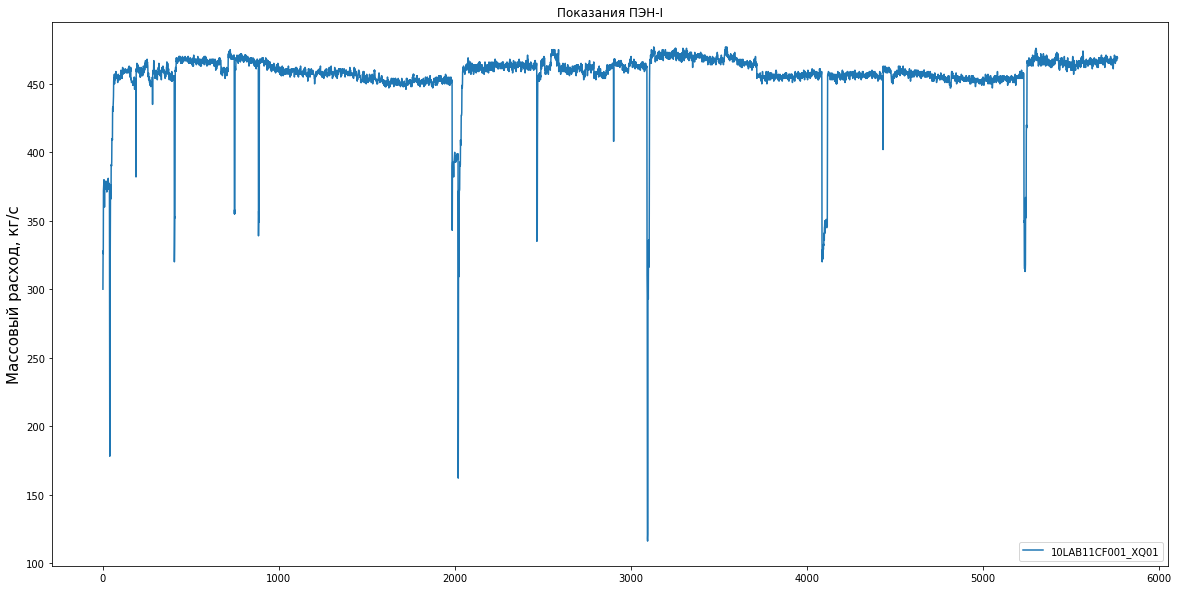

In [7]:
filtred_data['pump_1_mass'].plot(title="Показания ПЭН-I")
plt.ylabel("Массовый расход, кг/c", fontsize=15)

rolled = pump_mass_1_filtred.rolling(50).mean()
plt.legend(loc='lower right')

# rolled.plot(linewidth=3)

<h1>Сглаживание</h1>

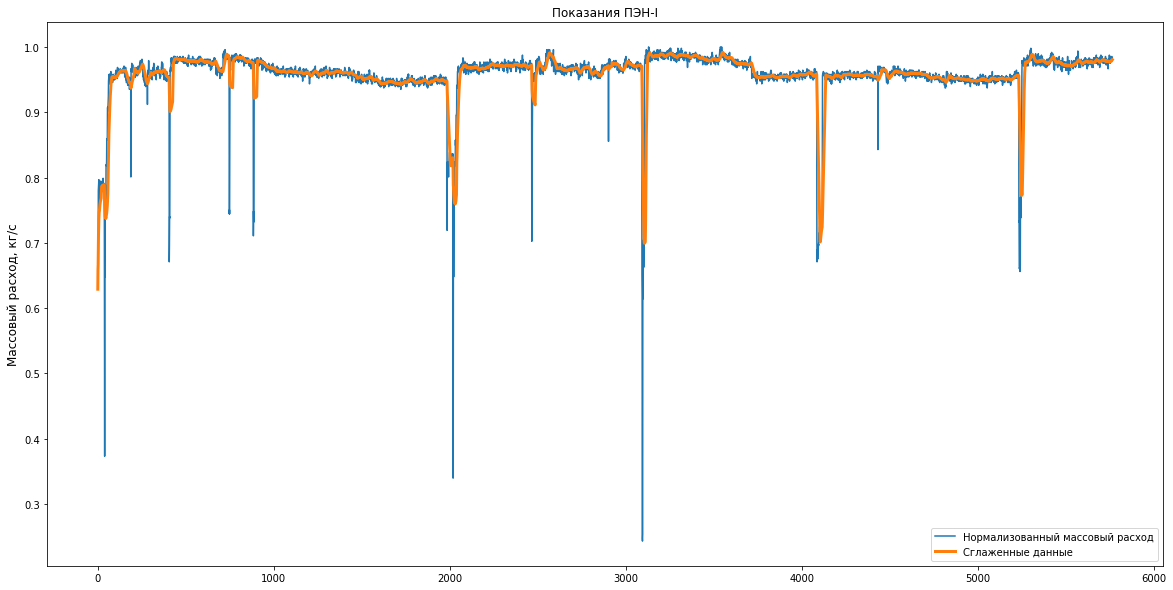

In [8]:
def smooth(data, rolling=20, min_periods=1):
    f_max = data.max()
    f_norm = data/f_max
    return f_norm.rolling(rolling, min_periods).mean()

pump_mass_1_filtred
pump_mass_1_max = filtred_data['pump_1_mass'].max()

pump_mass_1_norm = filtred_data['pump_1_mass'] / pump_mass_1_max
pump_mass_1_norm.plot(title="Показания ПЭН-I", label="Нормализованный массовый расход")
# plt.ylabel("Массовый расход", fontsize=15)

rolled_mass_1 = pump_mass_1_norm.rolling(20, min_periods=1).mean()
rolled_mass_1.plot(label='Сглаженные данные', linewidth=3)
plt.ylabel("Массовый расход, кг/c", fontsize=12)
plt.legend(loc='lower right')

smoothed_data = {
    'pump_1_in':smooth(filtred_data['pump_1_in']),
    'pump_2_in':smooth(filtred_data['pump_2_in']),
    'pump_3_in':smooth(filtred_data['pump_3_in']),
    'pump_4_in':smooth(filtred_data['pump_4_in']),
    'pump_5_in':smooth(filtred_data['pump_5_in']),
    
    
    'pump_1_out':smooth(filtred_data['pump_1_out']),
    'pump_2_out':smooth(filtred_data['pump_2_out']),
    'pump_3_out':smooth(filtred_data['pump_3_out']),
    'pump_4_out':smooth(filtred_data['pump_4_out']),
    'pump_5_out':smooth(filtred_data['pump_5_out']),
    
    
    'pump_1_mass':smooth(filtred_data['pump_1_mass']),
    'pump_2_mass':smooth(filtred_data['pump_2_mass']),
    'pump_3_mass':smooth(filtred_data['pump_3_mass']),
    'pump_4_mass':smooth(filtred_data['pump_4_mass']),
    'pump_5_mass':smooth(filtred_data['pump_5_mass']),
    
    'pump_1_eff':smooth(filtred_data['pump_1_eff']),
    'pump_2_eff':smooth(filtred_data['pump_2_eff']),
    'pump_3_eff':smooth(filtred_data['pump_3_eff']),
    'pump_4_eff':smooth(filtred_data['pump_4_eff']),
    'pump_5_eff':smooth(filtred_data['pump_5_eff']),
    
    'pump_1_temp':smooth(filtred_data['pump_1_temp']),
    'pump_2_temp':smooth(filtred_data['pump_2_temp']),
    'pump_3_temp':smooth(filtred_data['pump_3_temp']),
    'pump_4_temp':smooth(filtred_data['pump_4_temp']),
    'pump_5_temp':smooth(filtred_data['pump_5_temp']),
    
    'pump_1_revs':smooth(filtred_data['pump_1_revs']),
    'pump_2_revs':smooth(filtred_data['pump_2_revs']),
    'pump_3_revs':smooth(filtred_data['pump_3_revs']),
    'pump_4_revs':smooth(filtred_data['pump_4_revs']),
    'pump_5_revs':smooth(filtred_data['pump_5_revs']),
    
    'pump_1_amper':smooth(filtred_data['pump_1_amper']),
    'pump_2_amper':smooth(filtred_data['pump_2_amper']),
    'pump_3_amper':smooth(filtred_data['pump_3_amper']),
    'pump_4_amper':smooth(filtred_data['pump_4_amper']),
    'pump_5_amper':smooth(filtred_data['pump_5_amper']),
}



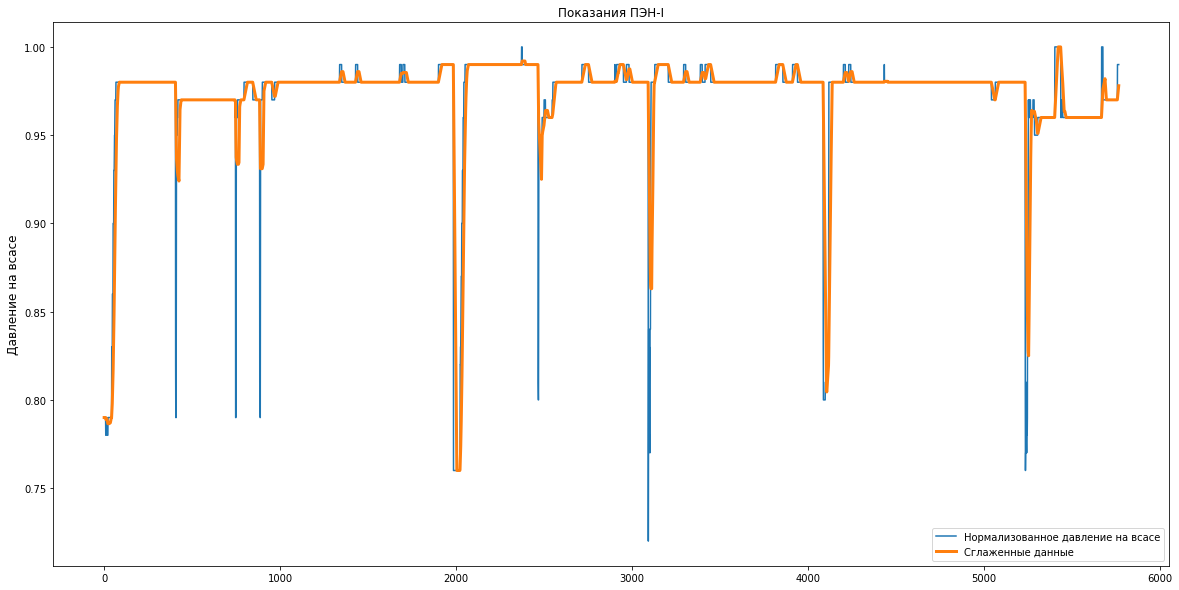

In [9]:
(filtred_data['pump_1_in']/filtred_data['pump_1_in'].max()).plot(title='Показания ПЭН-I', label="Нормализованное давление на всасе")
smoothed_data['pump_1_in'].plot(linewidth=3, label="Сглаженные данные")
plt.ylabel("Давление на всасе", fontsize=12)
plt.legend(loc="lower right")


<h1>Центрирование</h1>

In [10]:
# norm_pump_1_in = (filtred_data['pump_1_in']-filtred_data['pump_1_in'].mean())/filtred_data['pump_1_in']
# norm_pump_1_eff = (filtred_data['pump_1_eff']-filtred_data['pump_1_eff'].mean())/filtred_data['pump_1_eff']

# norm_pump_2_in = (filtred_data['pump_2_in']-filtred_data['pump_2_in'].mean())/filtred_data['pump_2_in']
# norm_pump_2_eff = (filtred_data['pump_2_eff']-filtred_data['pump_2_eff'].mean())/filtred_data['pump_2_eff']

# norm_pump_3_in = (filtred_data['pump_3_in']-filtred_data['pump_3_in'].mean())/filtred_data['pump_3_in']
# norm_pump_3_eff = (filtred_data['pump_3_eff']-filtred_data['pump_3_eff'].mean())/filtred_data['pump_3_eff']

In [11]:
# corr1 = np.corrcoef(norm_pump_1_in.to_numpy(), norm_pump_1_eff.to_numpy())
# corr2 = np.corrcoef(norm_pump_2_in.to_numpy(), norm_pump_2_eff.to_numpy())
# corr3 = np.corrcoef(norm_pump_3_in.to_numpy(), norm_pump_3_eff.to_numpy())


# norm_pump_1_eff
# print(corr1[0][1], corr2[0][1], corr3[0][1])
# filtred_df['pump_2_in']
# df[pump_in_cols[1]].plot()

In [12]:
norm_pump_1_in = (smoothed_data['pump_1_in']-smoothed_data['pump_1_in'].mean())/smoothed_data['pump_1_in']
norm_pump_1_eff = (smoothed_data['pump_1_eff']-smoothed_data['pump_1_eff'].mean())/smoothed_data['pump_1_eff']

norm_pump_2_in = (smoothed_data['pump_2_in']-smoothed_data['pump_2_in'].mean())/smoothed_data['pump_2_in']
norm_pump_2_eff = (smoothed_data['pump_2_eff']-smoothed_data['pump_2_eff'].mean())/smoothed_data['pump_2_eff']

norm_pump_3_in = (smoothed_data['pump_3_in']-smoothed_data['pump_3_in'].mean())/smoothed_data['pump_3_in']
norm_pump_3_eff = (smoothed_data['pump_3_eff']-smoothed_data['pump_3_eff'].mean())/smoothed_data['pump_3_eff']

centred_data = {
    'pump_1_in': (smoothed_data['pump_1_in']-smoothed_data['pump_1_in'].mean())/smoothed_data['pump_1_in'],
    'pump_2_in': (smoothed_data['pump_2_in']-smoothed_data['pump_2_in'].mean())/smoothed_data['pump_2_in'],
    'pump_3_in': (smoothed_data['pump_3_in']-smoothed_data['pump_3_in'].mean())/smoothed_data['pump_3_in'],
    'pump_4_in': (smoothed_data['pump_4_in']-smoothed_data['pump_4_in'].mean())/smoothed_data['pump_4_in'],
    'pump_5_in': (smoothed_data['pump_5_in']-smoothed_data['pump_5_in'].mean())/smoothed_data['pump_5_in'],

    'pump_1_out': (smoothed_data['pump_1_out']-smoothed_data['pump_1_out'].mean())/smoothed_data['pump_1_out'],
    'pump_2_out': (smoothed_data['pump_2_out']-smoothed_data['pump_2_out'].mean())/smoothed_data['pump_2_out'],
    'pump_3_out': (smoothed_data['pump_3_out']-smoothed_data['pump_3_out'].mean())/smoothed_data['pump_3_out'],
    'pump_4_out': (smoothed_data['pump_4_out']-smoothed_data['pump_4_out'].mean())/smoothed_data['pump_4_out'],
    'pump_5_out': (smoothed_data['pump_5_out']-smoothed_data['pump_5_out'].mean())/smoothed_data['pump_5_out'],

    'pump_1_eff': (smoothed_data['pump_1_eff']-smoothed_data['pump_1_eff'].mean())/smoothed_data['pump_1_eff'],
    'pump_2_eff': (smoothed_data['pump_2_eff']-smoothed_data['pump_2_eff'].mean())/smoothed_data['pump_2_eff'],
    'pump_3_eff': (smoothed_data['pump_3_eff']-smoothed_data['pump_3_eff'].mean())/smoothed_data['pump_3_eff'],
    'pump_4_eff': (smoothed_data['pump_4_eff']-smoothed_data['pump_4_eff'].mean())/smoothed_data['pump_4_eff'],
    'pump_5_eff': (smoothed_data['pump_5_eff']-smoothed_data['pump_5_eff'].mean())/smoothed_data['pump_5_eff'],
    
    'pump_1_temp': (smoothed_data['pump_1_temp']-smoothed_data['pump_1_temp'].mean())/smoothed_data['pump_1_temp'],
    'pump_2_temp': (smoothed_data['pump_2_temp']-smoothed_data['pump_2_temp'].mean())/smoothed_data['pump_2_temp'],
    'pump_3_temp': (smoothed_data['pump_3_temp']-smoothed_data['pump_3_temp'].mean())/smoothed_data['pump_3_temp'],
    'pump_4_temp': (smoothed_data['pump_4_temp']-smoothed_data['pump_4_temp'].mean())/smoothed_data['pump_4_temp'],
    'pump_5_temp': (smoothed_data['pump_5_temp']-smoothed_data['pump_5_temp'].mean())/smoothed_data['pump_5_temp'],

    'pump_1_revs': (smoothed_data['pump_1_revs']-smoothed_data['pump_1_revs'].mean())/smoothed_data['pump_1_revs'],
    'pump_2_revs': (smoothed_data['pump_2_revs']-smoothed_data['pump_2_revs'].mean())/smoothed_data['pump_2_revs'],
    'pump_3_revs': (smoothed_data['pump_3_revs']-smoothed_data['pump_3_revs'].mean())/smoothed_data['pump_3_revs'],
    'pump_4_revs': (smoothed_data['pump_4_revs']-smoothed_data['pump_4_revs'].mean())/smoothed_data['pump_4_revs'],
    'pump_5_revs': (smoothed_data['pump_5_revs']-smoothed_data['pump_5_revs'].mean())/smoothed_data['pump_5_revs'],

    'pump_1_amper': (smoothed_data['pump_1_amper']-smoothed_data['pump_1_amper'].mean())/smoothed_data['pump_1_amper'],
    'pump_2_amper': (smoothed_data['pump_2_amper']-smoothed_data['pump_2_amper'].mean())/smoothed_data['pump_2_amper'],
    'pump_3_amper': (smoothed_data['pump_3_amper']-smoothed_data['pump_3_amper'].mean())/smoothed_data['pump_3_amper'],
    'pump_4_amper': (smoothed_data['pump_4_amper']-smoothed_data['pump_4_amper'].mean())/smoothed_data['pump_4_amper'],
    'pump_5_amper': (smoothed_data['pump_5_amper']-smoothed_data['pump_5_amper'].mean())/smoothed_data['pump_5_amper'],
}

corr1 = np.corrcoef(centred_data['pump_1_in'].to_numpy(), centred_data['pump_1_eff'].to_numpy())
corr2 = np.corrcoef(centred_data['pump_2_in'].to_numpy(), centred_data['pump_2_eff'].to_numpy())
corr3 = np.corrcoef(centred_data['pump_3_in'].to_numpy(), centred_data['pump_3_eff'].to_numpy())


# norm_pump_1_eff
print(corr1[0][1], corr2[0][1], corr3[0][1])

print(np.corrcoef(centred_data['pump_3_in'].to_numpy(), centred_data['pump_3_eff'].to_numpy()))
# filtred_df['pump_2_in']
# df[pump_in_cols[1]].plot()

0.6890677477353913 0.6232086268162709 0.5693469461251821
[[1.         0.56934695]
 [0.56934695 1.        ]]
